With more and more n in ngrams the model becomes bigger and bigger (curse of dimensionality).
We can associate each word/char with a vector of 30/60/100 features. These are embeddings. Words close to each other should have simmilar embeddings.

Eg.
**A dog was running in a _.** It's not in the training set, so we're out of probabilty, but we know that a is close to 'the' and 'running' is close to 'walking', so we can look also at a context of these words (transfer knowledge)

We have a lookup table (17000 x 30 – words x embedding size)which translate the number of each word to it's embedding representation. All words are transferred to hidden layer with tanh activation function. Then the layer with softmax is used to predict the next word. 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]  

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
# build the dataset

def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        # print(word)
        context = [0] * block_size # padded context of 0 tokens ('...' → e)
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '→', ch)
            context = context[1:] + [ix] # move context window by 1 – crop and append

    X = torch.tensor(X) # default for Tensor is float32 and for LongTensor is int64, tensor adjusts
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [74]:
# split the dataset 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
block_size = 3 # context length

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [78]:
g = torch.Generator().manual_seed(2147483647)

# lookup table C
embedding_dim = 10
C = torch.randn([27, embedding_dim], generator=g)

# hidden layer
hidden_layer_size = 200
W1 = torch.randn((block_size * embedding_dim, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)

# output layer
W2 = torch.randn((hidden_layer_size, 27), generator=g) # we predict 27 characters
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [79]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [84]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [98]:
lri = []
lossi = []
stepi = []

In [99]:
for i in range(50000):
    # minibatch construction
    ix = torch.randint(0 , Xtr.shape[0], (32,)) # batchsize 32

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, block_size*embedding_dim) @ W1 + b1) # (32,100); -1 means we should keep the first dimension size
    # broadcasting for the bias works because we have
    # 32, 100
    #   , 100 → 1, 100 → it's multiplied to 32, 100 and added to each row

    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # updata
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.2959043979644775


For finding good learning rate we find the place where the loss barely decreases (0,001) and  where it explodes (1). When we sample beetween these numbers and change the lr in each iteration, loking for exploding.

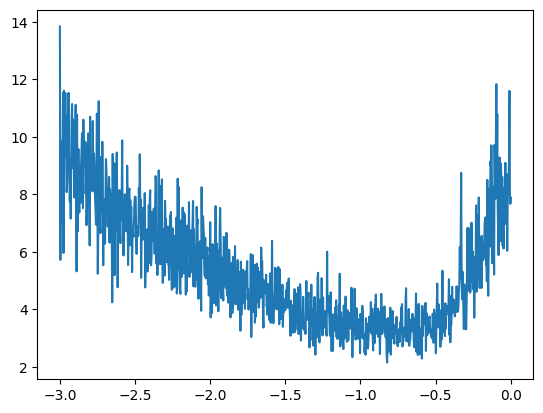

In [94]:
plt.plot(lri, lossi)

10**-1 = 0.1 is a good learning rate. We use it and then use learning rate decay.

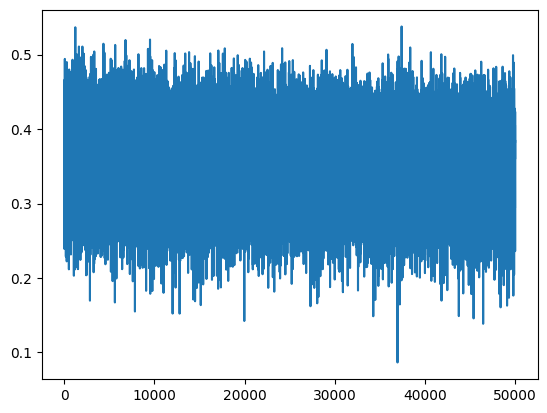

In [100]:
plt.plot(stepi, lossi)

Minibatches create noise in the data.

In [88]:
# loss on the whole dataset

def loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, embedding_dim*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

loss(Xtr, Ytr), loss(Xdev, Ydev)

(tensor(2.2692, grad_fn=<NllLossBackward0>),
 tensor(2.3132, grad_fn=<NllLossBackward0>))

Very positive logits makes very big exponent, sometimes reaching 'inf', so F.cross_entropy subtracts somenthing from the logits, what keeps the result the same, but avoiding the overflow. Also it's much more efficient than our own implementation.

The network with 3481 parameters easily overfits 32 training examples, reaching the loss of 0.255. We can't reach 0 loss, because e.g. `...` should predict `e`, `o` and `i` in the same time.

When we train whole dataset each iteration takes a lot of time. We'll use minibatches. With the minibatches of size 32 the quality of the gradient is lower, but the gradient direction is good enough. It's better to take more steps with a bit worse gradient than loose time evaluating exact gradient.

In [10]:
# explanation

print(emb.shape) # [32, 3, 2] – for each sample we have a an embedding of 2
# we could have used matrix multiplication and one hot encoding

print(X[13,2]) # second word of a context for 13th example
print(C[X[13,2]]) # it's embedding
print(C[1])

# concatenate inputs to feed them to hidden layer
# 32 x 3 x 2 → 32 x 6
# torch.unbind(emb, 1) == emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]
# torch.cat(torch.unbind(emb, 1), 1).shape # new tensor with new memory
# view is very efficient, because each vector has 'storage()' which is always 1D. 
# The view is just a different way to look at the same storage
emb.view(32, 6).shape

torch.Size([32, 3, 2])
tensor(1)
tensor([-0.0274, -1.1008], grad_fn=<SelectBackward0>)
tensor([-0.0274, -1.1008], grad_fn=<SelectBackward0>)


torch.Size([32, 6])

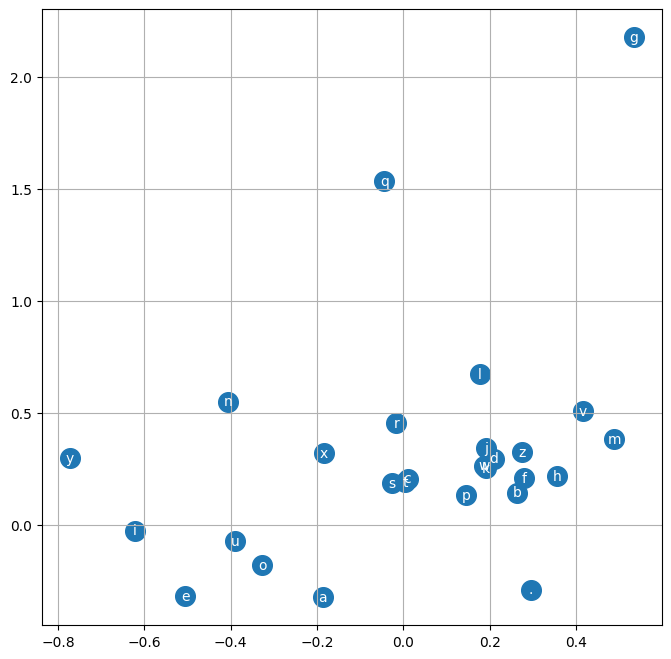

In [72]:
# visualise the embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha = "center", va="center", color="white")
plt.grid("minor")

consonant are together, ., q and g are separated

In [103]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out]))

mona.
kiyan.
see.
midhayah.
jethrettegrach.
adered.
elin.
shi.
jenleigh.
sananaraelyzi.
hotta.
noshubvrghan.
jestyn.
jowan.
kix.
teusan.
kenned.
riyah.
fieh.
yuma.
